# Feature Engineering Case Study

### İş problemi

Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin
edebilecek bir makine öğrenmesi modeli geliştirilmesi istenmektedir. Modeli
geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını
gerçekleştirmeniz beklenmektedir.

### Veri Setinin Hikayesi

Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır. ABD'deki
Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları üzerinde
yapılan diyabet araştırması için kullanılan verilerdir.
Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

## Proje Görevleri

# Görev 1: EDA

#### Adım 1: Genel resmi inceleyiniz.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [2]:
diabetes_ = pd.read_csv("diabetes.csv")
diabetes = diabetes_.copy()

In [3]:
print(diabetes.head())
print(diabetes.shape)
print(diabetes.dtypes)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 28.100                     0.167   21        0
4            0      137             40             35      168 43.100                     2.288   33        1
(768, 9)
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: 

In [4]:
print(diabetes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [5]:
diabetes.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

,0.000,0.050,0.500,0.950,0.990,1.000
Pregnancies,0.000,0.000,3.000,10.000,13.000,17.000
Glucose,0.000,79.000,117.000,181.000,196.000,199.000
BloodPressure,0.000,38.700,72.000,90.000,106.000,122.000
SkinThickness,0.000,0.000,23.000,44.000,51.330,99.000
Insulin,0.000,0.000,30.500,293.000,519.900,846.000
BMI,0.000,21.800,32.000,44.395,50.759,67.100
DiabetesPedigreeFunction,0.078,0.140,0.372,1.133,1.698,2.420
Age,21.000,21.000,29.000,58.000,67.000,81.000
Outcome,0.000,0.000,0.000,1.000,1.000,1.000


### Adım 2: Numerik ve kategorik değişkenleri yakalayınız.

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """


    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

# sayısını raporlamak için
cat_cols, num_cols, cat_but_car = grab_col_names(diabetes)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


### Adım 3: Numerik ve kategorik değişkenlerin analizini yapınız.

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


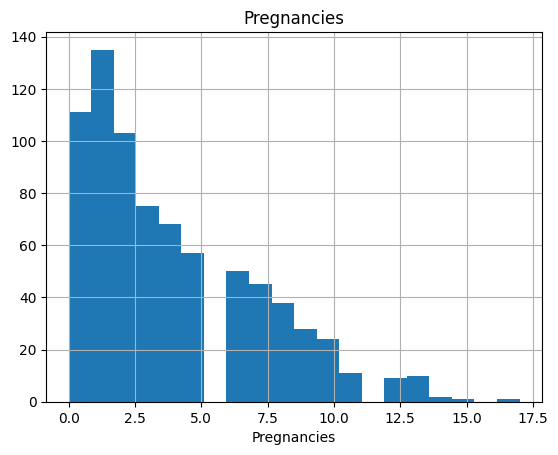

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


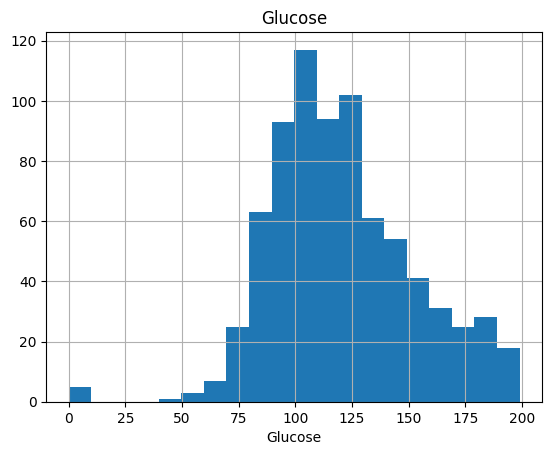

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


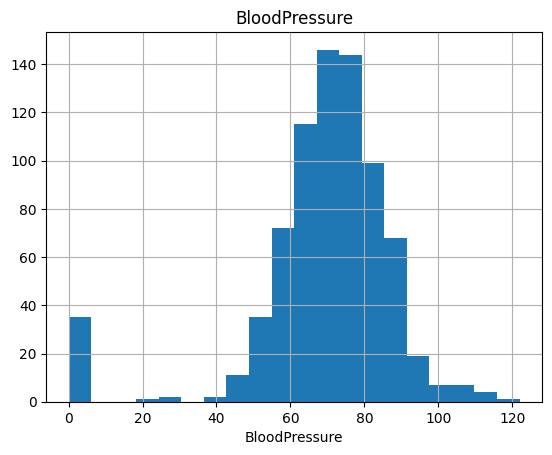

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


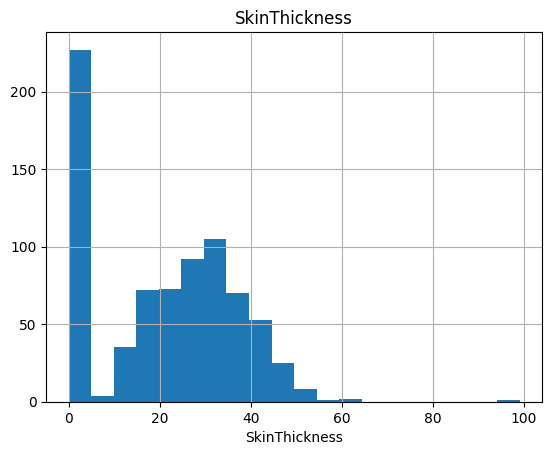

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


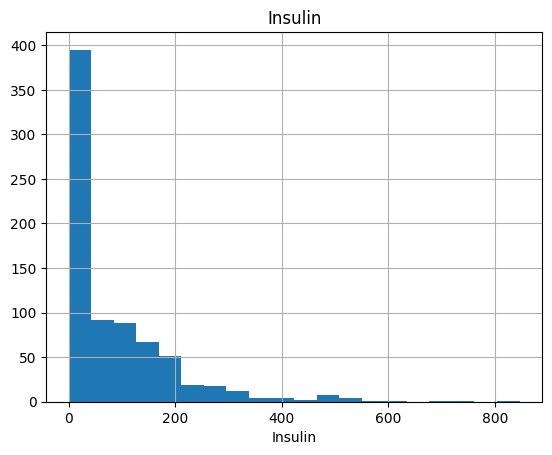

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


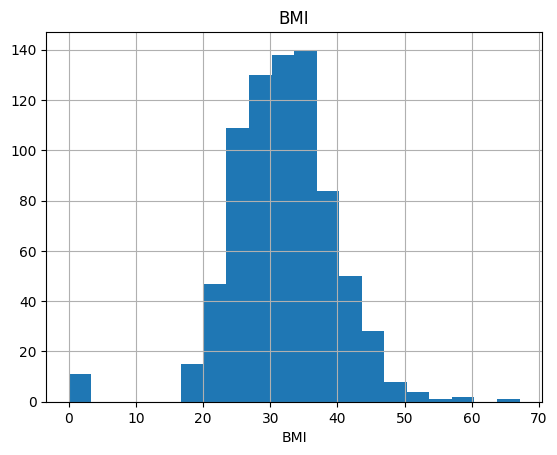

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


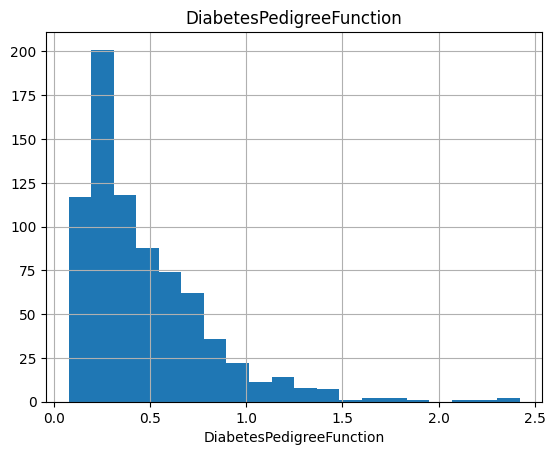

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


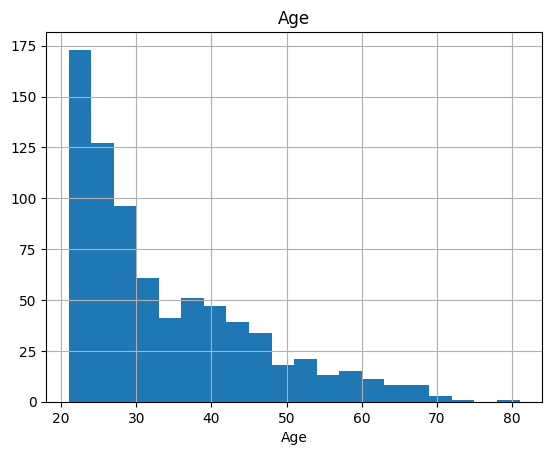

In [9]:
# numerik değişkenlerin analizi

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(diabetes, col, plot=True)

In [10]:
# kategorik değişkenlerin analizi

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(diabetes, col)

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896


### Adım 4: Hedef değişken analizi yapınız.

In [13]:
# kategorik değişkenlere göre hedef değişkenin ortalaması

for col in cat_cols:
    print(pd.DataFrame({col: diabetes.groupby(col)["Outcome"].mean()}))

         Outcome
Outcome         
0          0.000
1          1.000


In [14]:
# hedef değişkene göre numerik değişkenlerin ortalaması

for col in num_cols:
    print(diabetes.groupby("Outcome").agg({col: "mean"}))

         Pregnancies
Outcome             
0              3.298
1              4.866
         Glucose
Outcome         
0        109.980
1        141.257
         BloodPressure
Outcome               
0               68.184
1               70.825
         SkinThickness
Outcome               
0               19.664
1               22.164
         Insulin
Outcome         
0         68.792
1        100.336
           BMI
Outcome       
0       30.304
1       35.143
         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550
           Age
Outcome       
0       31.190
1       37.067


### Adım 5: Aykırı gözlem analizi yapınız.

In [15]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

print(outlier_thresholds(diabetes, "Pregnancies"))
print(outlier_thresholds(diabetes, "Glucose"))
print(outlier_thresholds(diabetes, "BloodPressure"))
print(outlier_thresholds(diabetes, "SkinThickness"))
print(outlier_thresholds(diabetes, "Insulin"))
print(outlier_thresholds(diabetes, "BMI"))
print(outlier_thresholds(diabetes, "DiabetesPedigreeFunction"))
print(outlier_thresholds(diabetes, "Age"))
print(outlier_thresholds(diabetes, "Outcome"))


(-15.0, 25.0)
(-74.0, 334.0)
(-38.249999999999986, 166.95)
(-66.0, 110.0)
(-439.5, 732.5)
(-12.09249999999999, 78.2875)
(-1.3483999999999996, 2.621599999999999)
(-34.5, 113.5)
(-1.5, 2.5)


In [19]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    print(f"{col}: {check_outlier(diabetes, col)}")

Pregnancies: False
Glucose: False
BloodPressure: False
SkinThickness: False
Insulin: True
BMI: False
DiabetesPedigreeFunction: False
Age: False


sadece Insulin değişkeninde outlier var

### Adım 6: Eksik gözlem analizi yapınız.

In [ ]:
diabetes.isnull().sum().sum()

0

In [ ]:
diabetes.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


### Adım 7: Korelasyon analizi yapınız.

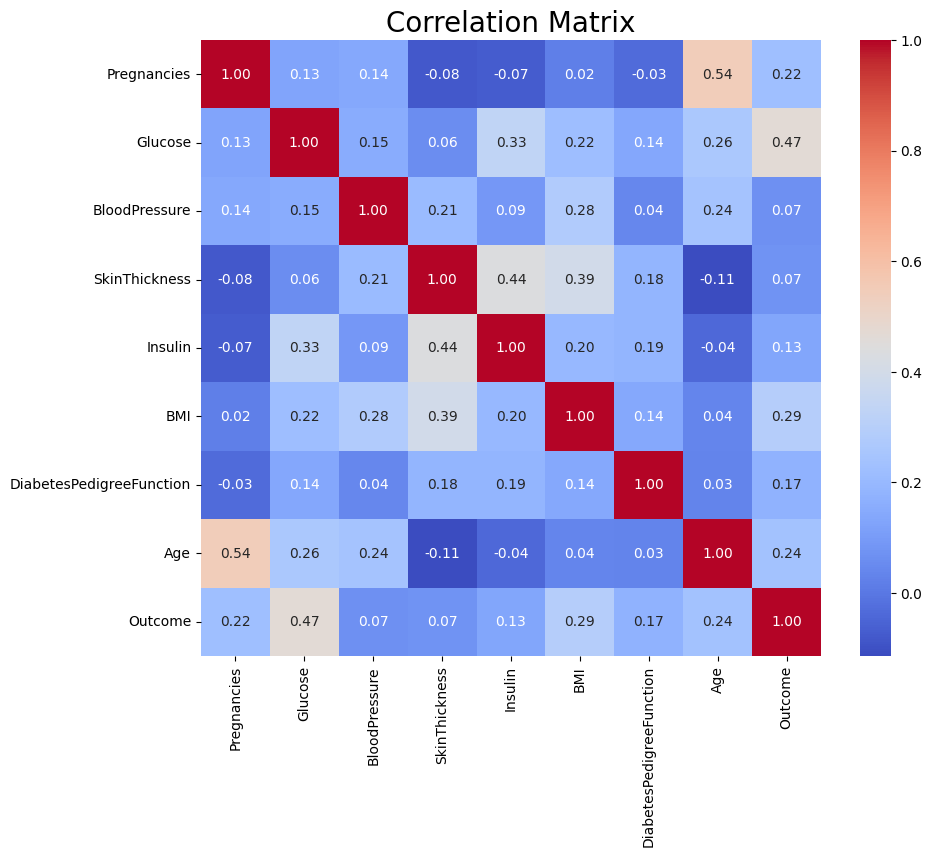

In [21]:
# Korelasyon Matrisi Oluşturma
plt.figure(figsize=(10, 8))
sns.heatmap(diabetes.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix", fontsize=20)
plt.show()

In [24]:
y = diabetes["Outcome"]
X = diabetes.drop("Outcome", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.7207792207792207
Precision: 0.6071428571428571
Recall: 0.6181818181818182
F1 Score: 0.6126126126126126
ROC AUC: 0.9828282828282828


<ipython-input-28-cfb86f70adc9>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Value", y="Feature",


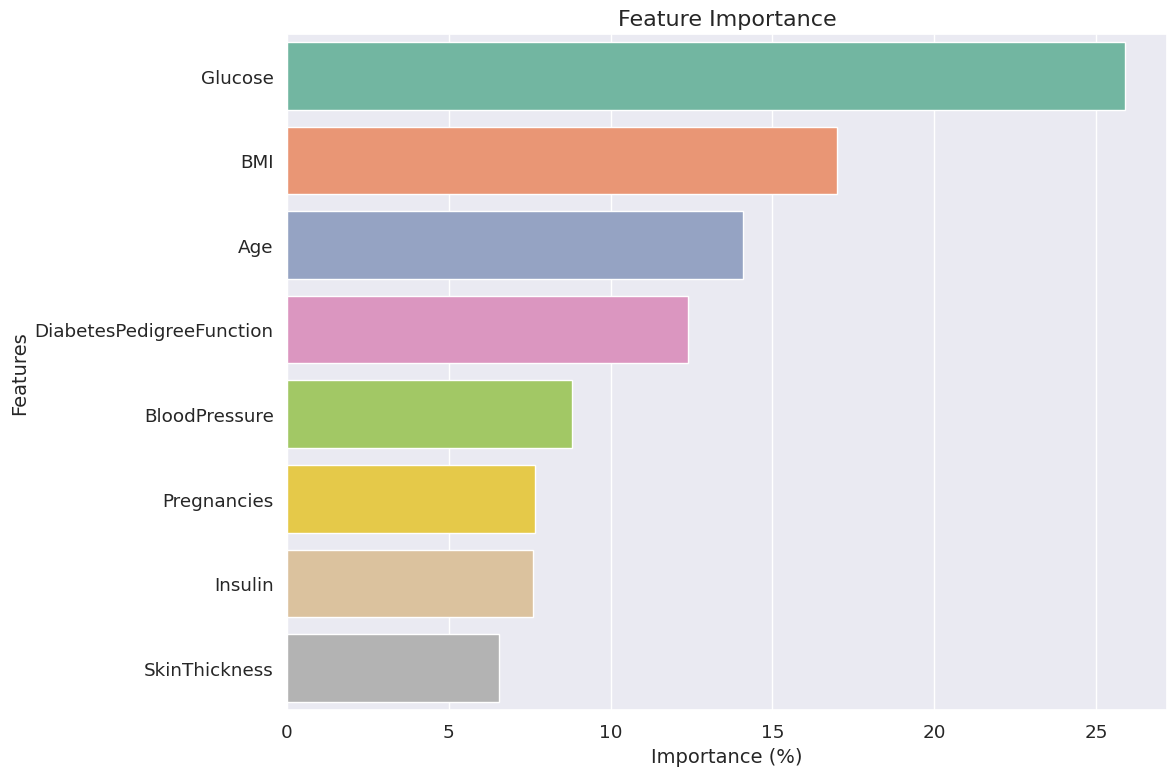

In [28]:
def plot_importance(model, features, num=None, palette="viridis", title="Feature Importance", save=False):
    if num is None:
        num = len(features.columns)

    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    feature_imp["Value"] = feature_imp["Value"] * 100

    plt.figure(figsize=(12, 8))
    sns.set(font_scale=1.2)

    palette = sns.color_palette("Set2", num)
    sns.barplot(x="Value", y="Feature",
                data=feature_imp.sort_values(by="Value", ascending=False)[0:num], palette=palette)

    plt.title(title, fontsize=16)
    plt.xlabel("Importance (%)", fontsize=14)
    plt.ylabel("Features", fontsize=14)

    plt.tight_layout()
    plt.show(block=True)

    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X, palette="coolwarm")

# Görev 2: Feature Engineering

### Adım 1: Eksik ve aykırı değerler için gerekli işlemleri yapınız. Veri setinde eksik gözlem bulunmamakta ama Glikoz, Insulin vb. değişkenlerde 0 değeri içeren gözlem birimleri eksik değeri ifade ediyor olabilir. Örneğin; bir kişinin glikoz veya insulin değeri 0 olamayacaktır. Bu durumu dikkate alarak sıfır değerlerini ilgili değerlerde NaN olarak atama yapıp sonrasında eksik değerlere işlemleri uygulayabilirsiniz.

In [39]:
selected=["Glucose","SkinThickness","Insulin","BMI","BloodPressure"]

for col in selected:
    diabetes[col]= diabetes[col].apply(lambda x: np.nan if x==0 else x)

In [40]:
diabetes.isnull().sum().sum()

652

In [41]:
diabetes.isnull().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [42]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


missing_values_table(diabetes)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


In [43]:
missing_values_table(diabetes, True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [44]:
for col in selected:
    diabetes[col]=diabetes[col].fillna(diabetes.groupby("Outcome")[col].transform("mean"))

In [45]:
diabetes.isnull().sum().sum()

0

In [46]:
diabetes.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [47]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.000,72.000,35.000,206.846,33.600,0.627,50,1
1,1,85.000,66.000,29.000,130.288,26.600,0.351,31,0
2,8,183.000,64.000,33.000,206.846,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [48]:
# aykırı değer

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    print(col, check_outlier(diabetes, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [49]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(diabetes, col)

for col in num_cols:
    print(col, check_outlier(diabetes, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


<ipython-input-49-1aefe98af4b8>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-34.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


In [50]:
diabetes.columns = diabetes.columns.str.title()
diabetes.columns

Index(['Pregnancies', 'Glucose', 'Bloodpressure', 'Skinthickness', 'Insulin', 'Bmi', 'Diabetespedigreefunction', 'Age', 'Outcome'], dtype='object')

In [51]:
diabetes = diabetes.rename({'Bloodpressure':'Blood Pressure'},axis='columns')
diabetes.columns

Index(['Pregnancies', 'Glucose', 'Blood Pressure', 'Skinthickness', 'Insulin', 'Bmi', 'Diabetespedigreefunction', 'Age', 'Outcome'], dtype='object')

In [52]:
diabetes = diabetes.rename({'Skinthickness':'Skin Thickness'},axis='columns')
diabetes.columns

Index(['Pregnancies', 'Glucose', 'Blood Pressure', 'Skin Thickness', 'Insulin', 'Bmi', 'Diabetespedigreefunction', 'Age', 'Outcome'], dtype='object')

In [53]:
diabetes = diabetes.rename({'Diabetespedigreefunction':'Diabetes Pedigree Function'},axis='columns')
diabetes.columns

Index(['Pregnancies', 'Glucose', 'Blood Pressure', 'Skin Thickness', 'Insulin', 'Bmi', 'Diabetes Pedigree Function', 'Age', 'Outcome'], dtype='object')

## Adım 2: Yeni değişkenler oluşturunuz.

In [55]:
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Normal'
    elif 25 <= bmi < 29.9:
        return 'Overweight'
    else:
        return 'Obese'

diabetes['BMICategory'] = diabetes['Bmi'].apply(categorize_bmi)

def categorize_age(age):
    if age < 30:
        return 'Young'
    elif 30 <= age < 50:
        return 'Middle-aged'
    else:
        return 'Senior'

diabetes['AgeGroup'] = diabetes['Age'].apply(categorize_age)

print(diabetes[['BMICategory', 'AgeGroup']].head())

  BMICategory     AgeGroup
0       Obese       Senior
1  Overweight  Middle-aged
2      Normal  Middle-aged
3  Overweight        Young
4       Obese  Middle-aged


## Adım 3: Encoding işlemlerini gerçekleştiriniz.

In [56]:
# One-hot encoding ile kategorik değişkenleri sayısal hale getiriyoruz
diabetes_encoded = pd.get_dummies(diabetes, columns=['BMICategory', 'AgeGroup'], drop_first=True)
print(diabetes_encoded.head())

   Pregnancies  Glucose  Blood Pressure  Skin Thickness  Insulin    Bmi  Diabetes Pedigree Function    Age  Outcome  BMICategory_Obese  BMICategory_Overweight  BMICategory_Underweight  AgeGroup_Senior  AgeGroup_Young
0            6  148.000          72.000          35.000  206.846 33.600                       0.627 50.000        1               True                   False                    False             True           False
1            1   85.000          66.000          29.000  130.288 26.600                       0.351 31.000        0              False                    True                    False            False           False
2            8  183.000          64.000          33.000  206.846 23.300                       0.672 32.000        1              False                   False                    False            False           False
3            1   89.000          66.000          23.000   94.000 28.100                       0.167 21.000        0              Fal

## Adım 4: Numerik değişkenler için standartlaştırma yapınız.

In [57]:
numerical_features = diabetes_encoded.drop('Outcome', axis=1)
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)
diabetes_scaled = pd.DataFrame(numerical_features_scaled, columns=numerical_features.columns)
diabetes_scaled['Outcome'] = diabetes_encoded['Outcome'].values
print(diabetes_scaled.head())

   Pregnancies  Glucose  Blood Pressure  Skin Thickness  Insulin    Bmi  Diabetes Pedigree Function    Age  BMICategory_Obese  BMICategory_Overweight  BMICategory_Underweight  AgeGroup_Senior  AgeGroup_Young  Outcome
0        0.640    0.864          -0.035           0.654    0.582  0.168                       0.468  1.426              0.755                  -0.541                   -0.072            2.762          -1.032        1
1       -0.845   -1.205          -0.531          -0.026   -0.305 -0.850                      -0.365 -0.191             -1.324                   1.848                   -0.072           -0.362          -1.032        0
2        1.234    2.014          -0.697           0.427    0.582 -1.330                       0.604 -0.106             -1.324                  -0.541                   -0.072           -0.362          -1.032        1
3       -0.845   -1.074          -0.531          -0.707   -0.726 -0.632                      -0.921 -1.042             -1.324       

## Adım 5: Model oluşturunuz.

Accuracy: 0.88


<ipython-input-28-cfb86f70adc9>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Value", y="Feature",


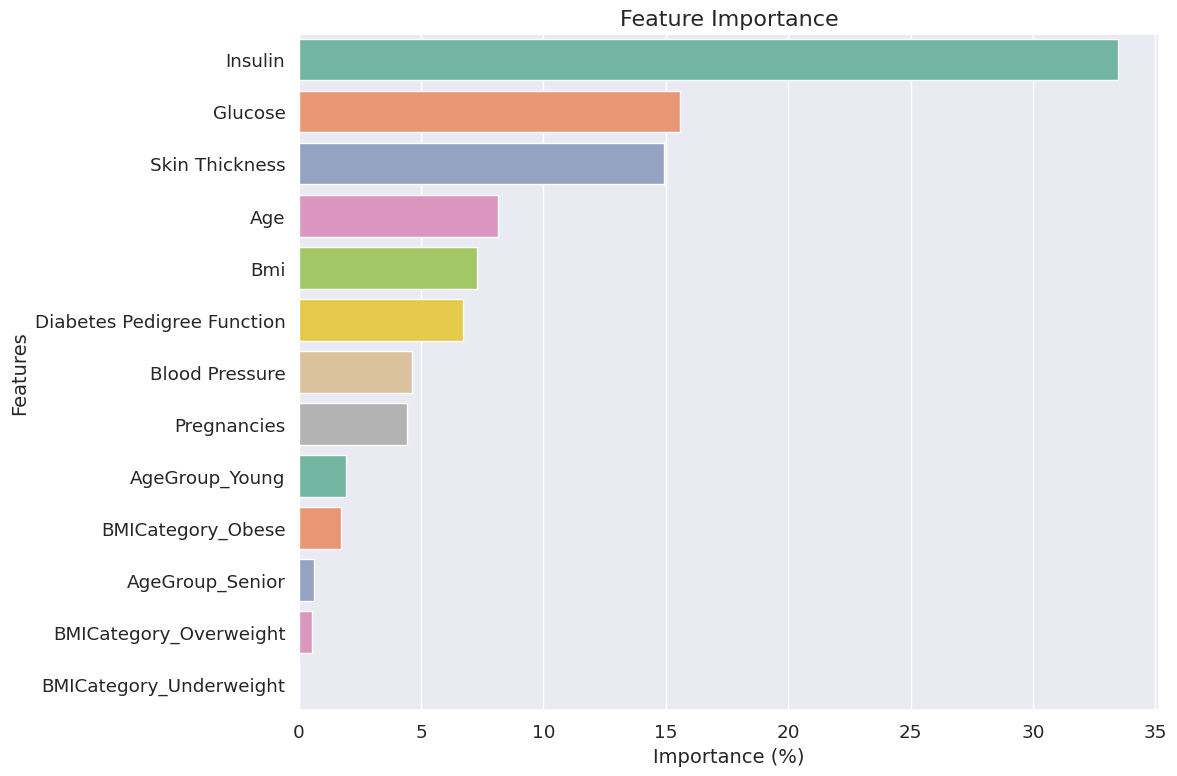

In [60]:
X = diabetes_scaled.drop("Outcome", axis=1)
y = diabetes_scaled["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plot_importance(rf_model, X)